In [4]:
from nltk.stem import PorterStemmer
import pandas as pd
import re
import string
import nltk
import numpy as np 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [5]:
df=pd.read_csv('train.csv')
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.50,random_state=101)

In [70]:
import matplotlib.pyplot as plt
f=plt.figure()
plt.bar(range(0,2), [len(df[df['sentiment']==1]),len(df[df['sentiment']==0])])
plt.xticks(range(0,2), ['Postive', 'Negative'])
plt.ylabel('Number of Reviews')
plt.xlabel('Postive and Negative Reviews')
plt.title('Movie Reviews')
plt.show()
f.savefig("Moview_review.png",bbox_inches='tight', pad_inches=0.2, dpi=300)

<Figure size 432x288 with 0 Axes>

In [6]:
df=list(X_train);

In [7]:
#cleaning
text=[];
ps = PorterStemmer() 
for i in range(0,len(df)):
    DF=(df[i]).translate(str.maketrans('', '', string.punctuation))#remove punctuation
    DF=DF.lower()#make lowercase
    text.append(DF); 

In [8]:
tagged=[];
stop_words=set(stopwords.words('english'))
filtered_sentence=[]; 
for i in range(0,len(text)): 
    word_tokens=word_tokenize(text[i][:]) 
    tagged.append(nltk.pos_tag(word_tokens))#tokenize words POS

In [9]:
from itertools import chain 
flatten_list = list(chain.from_iterable(tagged)) 
SenW=[];
SenPOS=[];
for i in range(0,len(flatten_list)):
    SenW.append(flatten_list[i][0]);
    SenPOS.append(flatten_list[i][1]);  
WordRest=[];
for i in range(0,len(SenPOS)):
    if (list(SenPOS[i]))[0]=='J' or (list(SenPOS[i]))[0]=='V' or (list(SenPOS[i]))[0]=='R':
        WordRest.append(SenW[i])
    elif SenPOS[i]=='IN' or SenPOS[i]=='PDT' or SenPOS[i]=='CC' or SenPOS[i]=='MD': 
        WordRest.append(SenW[i])

In [10]:
TotWordNum=0;
CleanTotNum=0;
for k in range(0,len(df)):
    TotWordNum += len(df[k]);
    CleanTotNum += len(tagged[k]);

In [11]:
filtered_sentence=[];
filtered1_sentence=[] 
for w in WordRest: 
    if w not in stop_words: 
        filtered1_sentence.append(ps.stem(w)) 
filtered_sentence.append(filtered1_sentence)#Removing stopwords and taking word roots
unqw=[];

In [12]:
for sentence in filtered_sentence:
    for w in sentence:
        if w not in unqw:
            unqw.append(w)

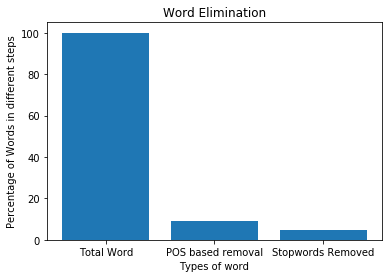

In [67]:
import matplotlib.pyplot as plt
f = plt.figure()
Review = [100,(len(WordRest)/TotWordNum)*100,(len(filtered_sentence[0])/TotWordNum)*100];
plt.bar(range(0,3), Review)
plt.xticks(range(0,3), ['Total Word','POS based removal','Stopwords Removed'])
plt.ylabel('Percentage of Words in different steps')
plt.xlabel('Types of word')
plt.title('Word Elimination')
#plt.show()
f.savefig("Wordsremoval.png",bbox_inches='tight', pad_inches=0.2, dpi=300)

In [13]:
#ordering word in terms of frequency
Freq_count=[[0]*len(unqw)];
for i in range(0,len(filtered_sentence[0])):
    for m in range(0,len(unqw)):
        if filtered_sentence[0][i]==unqw[m]:
            Freq_count[0][m]+=1;
            break;

In [14]:
GH=pd.DataFrame({'Frequency':Freq_count[0],'Word':unqw})

In [15]:
Tc=4000; # Feature Size
Unique=GH['Word'][(GH['Frequency'].nlargest(Tc)).index]
KL=list(Unique);

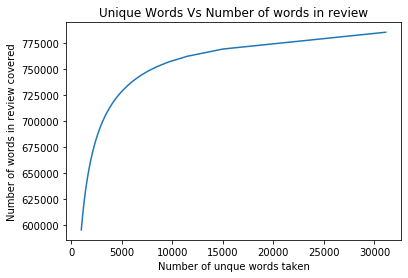

In [61]:
LenWord=[];
#Taking number of unique words and check how many words are covered
for Tc in range(1000,len(unqw),10):
    LenWord.append(sum(GH['Frequency'].nlargest(Tc))); 
f = plt.figure()    
len(LenWord), len(range(2000,len(unqw),10)) 
plt.plot(range(1000,len(unqw),10), LenWord)
#plt.xticks(range(0,5), ['Total Word','Clean Word','POS Remove','SW remove','Unique Word'])
plt.ylabel('Number of words in review covered')
plt.xlabel('Number of unque words taken')
plt.title('Unique Words Vs Number of words in review')
plt.show()
f.savefig("UnqwvsTotal.png",bbox_inches='tight', pad_inches=0.2,dpi=300)

In [16]:
Tr=len(y_train);
Number=list([0]*(Tc*Tr));
for i in range(0,Tr): #for i in range(0,len(df)-1):
    for m in range(0,Tc):#for m in range(0,len(uword)-1):
        XX=len(re.findall(KL[m],text[i][:]));
        Number[m+i*Tc] += XX;
Feat=np.reshape(Number,(Tr,Tc))  

In [17]:
X1=pd.concat([pd.DataFrame(Feat)],axis=1);

In [18]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [19]:
#clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
clf.fit(X1, y_train)
ypred=clf.predict(X1)
Train_score=(accuracy_score(y_train, ypred, normalize=False))/12500;

In [684]:
TP=0;
TN=0;
FP=0;
FN=0;
yt=list(y_train);
yp=list(ypred);
for i in range(0,12500):
    if yt[i]==1:
        if yp[i]==1:
            TP+=1;
        else:
            TN+=1;
    elif yt[i]==0:
        if yp[i]==1:
            FP+=1;
        else:    
            FN+=1; 
Confusion_Matrix=[[TP,TN],[FP,FN]];            

In [685]:
Confusion_Matrix

[[5464, 826], [379, 5831]]

In [45]:
clff = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0001, n_estimators=150,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,warm_start=False)

In [46]:
clff.fit(X1, y_train)
y_pred1=clff.predict(X1)
Train_score_X=(accuracy_score(y_train, y_pred1, normalize=False))/12500;

In [24]:
df1=list(X_test)

In [25]:
text1=[];
for i in range(0,len(df1)):
    DF1=(df1[i]).translate(str.maketrans('', '', string.punctuation))#remove punctuation
    DF1=DF1.lower()#make lowercase
    text1.append(DF1); 

In [27]:
Tr1=len(df1);
Number=list([0]*(Tc*Tr1));
for i in range(0,Tr1): #for i in range(0,len(df)-1):
    for m in range(0,Tc):#for m in range(0,len(uword)-1):
        XX=len(re.findall(KL[m],text1[i][:]));
        Number[m+i*Tc] += XX;
Feat1=np.reshape(Number,(Tr1,Tc))

In [28]:
X_1=pd.concat([pd.DataFrame(Feat1)],axis=1);

In [663]:
y_pred=clf.predict(X_1)
Test_score=clf.score(X_1, y_test)

In [49]:
y_pred_1=clff.predict(X_1)
Testt_score=clff.score(X_1, y_test)

In [33]:
TP=0;
TN=0;
FP=0;
FN=0;
yt=list(y_test);
yp=list(y_pred);
for i in range(0,12500):
    if yt[i]==1:
        if yp[i]==1:
            TP+=1;
        else:
            TN+=1;
    elif yt[i]==0:
        if yp[i]==1:
            FP+=1;
        else:    
            FN+=1; 
Confusion_Matrix=[[TP,TN],[FP,FN]];  

In [34]:
Confusion_Matrix

[[4871, 1339], [934, 5356]]